# ノートブック07: 多層パーセプトロン (MLP) の基礎

## 学習目標

このノートブックでは、多層パーセプトロン (Multi-Layer Perceptron, MLP) の基礎を学びます:

1. **ニューラルネットワークの基礎**
   - パーセプトロンから多層ネットワークへ
   - ニューロン、重み、バイアスの役割
   - 順伝播 (Forward Propagation)

2. **活性化関数**
   - Sigmoid、Tanh、ReLU、Leaky ReLU
   - 各関数の特性と使い分け
   - 勾配消失問題

3. **MLPの構造**
   - 入力層、隠れ層、出力層
   - ネットワークの深さと幅
   - パラメータ数の計算

4. **学習プロセス**
   - 損失関数
   - 最適化アルゴリズム (SGD、Adam)
   - 学習曲線の解釈

5. **実践例**
   - 非線形分類問題
   - ハイパーパラメータの影響
   - モデルの診断

---

## セットアップ

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, make_circles, load_digits
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

# ランダムシード固定
np.random.seed(42)

print("Setup complete!")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


Setup complete!


---

## 1. 活性化関数: ニューラルネットワークの非線形性

### 🤔 なぜ活性化関数が必要なのか？

活性化関数は、ニューラルネットワークに**非線形性**を導入します。
これがないと、ニューラルネットワークは**全く意味がない**ものになってしまいます。

---

### 📐 線形変換の組み合わせは、結局「線形」

#### ニューラルネットワークの基本計算

```
1層目: h₁ = W₁ × x + b₁
2層目: h₂ = W₂ × h₁ + b₂
3層目: y  = W₃ × h₂ + b₃
```

もし活性化関数がなければ、これを展開すると：

```
y = W₃ × (W₂ × (W₁ × x + b₁) + b₂) + b₃
  = W₃ × W₂ × W₁ × x + (W₃ × W₂ × b₁ + W₃ × b₂ + b₃)
  = W' × x + b'

ここで W' = W₃ × W₂ × W₁（1つの行列）
      b' = 定数ベクトル

→ 結局、y = W' × x + b' という1層の線形変換と同じ！
```

**つまり**: 活性化関数なしでは、100層重ねても1層と同じ表現力しかない！

#### 具体的な数値例

```
【2層のネットワーク（活性化関数なし）】

入力: x = 3

1層目: h = 2x + 1 = 2×3 + 1 = 7
2層目: y = 3h - 2 = 3×7 - 2 = 19

これを1つの式にすると:
y = 3(2x + 1) - 2 = 6x + 3 - 2 = 6x + 1

→ 結局 y = 6x + 1 という直線！
→ 2層使った意味がない
```

---

### 🎯 線形変換だけでは何ができないのか？

```
【XOR問題：線形では解けない典型例】

入力        出力
(0, 0)  →   0
(0, 1)  →   1
(1, 0)  →   1
(1, 1)  →   0

      y
      ↑
    1 │  ●       ○
      │
    0 │  ○       ●
      └──────────→ x
         0       1

○ = 出力0、● = 出力1

どんな直線を引いても、○と●を分離できない！
→ 線形変換だけでは絶対に学習不可能
```

**現実のデータも同様**:
- 画像認識: 「猫」と「犬」は直線で分けられない
- 音声認識: 同じ言葉でも波形は複雑に変化
- 自然言語: 文脈によって意味が変わる

---

### 💡 非線形活性化関数で何が変わるのか？

活性化関数を入れると、「曲がる」ことができるようになる！

```
【活性化関数ありの場合】

1層目: h₁ = σ(W₁ × x + b₁)  ← σは活性化関数
2層目: h₂ = σ(W₂ × h₁ + b₂)
3層目: y  = σ(W₃ × h₂ + b₃)

→ σが非線形なので、展開しても1つの行列にならない！
→ 層を重ねるほど、より複雑なパターンを表現できる
```

#### 直感的なイメージ

```
【線形のみ】
  入力 → [直線的変換] → [直線的変換] → [直線的変換] → 出力
         ＼＿＿＿＿＿＿＿結局1本の直線＿＿＿＿＿＿＿／

【非線形あり】
  入力 → [変換+曲げ] → [変換+曲げ] → [変換+曲げ] → 出力
              ↓            ↓            ↓
          曲がる点が    さらに曲がる   もっと曲がる
          
→ 最終的に非常に複雑な曲線（決定境界）を作れる！
```

---

### 🔍 ReLUは直線なのに、なぜ非線形？

ReLU: $f(x) = \max(0, x)$ は確かに「折れ線」に見えます。

```
        y
        ↑
        │      ／
        │    ／
        │  ／
   ─────●────────→ x
        │
        
x < 0: y = 0（水平線）
x ≥ 0: y = x（傾き1の直線）

→ 2本の直線の組み合わせ
→ でも「折れている」ので非線形！
```

#### なぜ折れ線でも十分なのか？

```
【1つのReLUニューロン】
  x < 0 なら 0
  x ≥ 0 なら x

【複数のReLUニューロンを組み合わせると...】

  入力 x に対して:
  
  ニューロン1: ReLU(x - 1)     → x=1 で折れる
  ニューロン2: ReLU(x - 2)     → x=2 で折れる
  ニューロン3: ReLU(-x + 3)    → x=3 で折れる
  
  これらを重み付けして足すと:
  
        y
        ↑
        │    ╱╲
        │   ╱  ╲
        │  ╱    ╲
        │ ╱      ╲
   ─────╱────────╲───→ x
        1   2    3
        
→ 折れ線を組み合わせて、どんな形も近似できる！
```

#### 数学的な事実（普遍近似定理）

```
【普遍近似定理 (Universal Approximation Theorem)】

十分な数のニューロンを持つ1層のニューラルネットワークは、
任意の連続関数を任意の精度で近似できる。

ReLUでも、Sigmoidでも、折れ線でも曲線でも、
「非線形」であれば近似能力を持つ！

直感:
  - ReLUは「折れ線」を作る
  - 折れ線をたくさん組み合わせる
  - 滑らかな曲線を近似できる（折り紙のイメージ）

実用上の重要な制約:

必要ユニット数: 望む精度に対して N が天文学的になることがある（実用的ではない）。
学習可能性: 定理は「適切な重みが存在する」ことを示すのみ。最適な重みをデータから勾配法で見つけられる保証はない。
一般化とデータ量: パラメータ数が多いと学習データが膨大に必要になりやすい（サンプル複雑度の問題）。
計算コスト: メモリ・推論時間が現実的でなくなる場合がある。
なぜ深さ（ディープ）が実用で有利か:

パラメータ効率: 深いネットワークは同じ表現を浅いネットで実現するよりはるかに少ないパラメータで済む場合がある（表現効率の指数的差）。
合成構造へのマッチ: 自然データ（画像・音声・言語）は階層的・合成的な構造を持つことが多く、深いネットはその構造に合わせて効果的に表現できる。
理論的分離結果: Telgarsky, Eldan & Shamir, Montúfar らの研究は「ある種の関数は浅いネットでは指数的な幅が要るが、深いネットなら多項式で表現可能」といった深さの利点を示している。
実装上のバイアス: CNN の局所性や畳み込み共有、Transformer の自己注意などの構造化バイアスが学習・一般化を助ける。
直感的な例: 積や階層的フィーチャー（小さなパーツ→中くらいのパーツ→全体）を組み合わせる関数は、深さを用いると逐次的に組み上げられるため効率的。一方で浅い和で同等を表現しようとするとパーツの組合せごとに多数のユニットが必要になる。

まとめ: 普遍近似定理は「可能性の存在」を保証する強力な理論だが、実用的な学習／計算／一般化の観点では深さ・構造化が大きな利点をもたらすため、深層学習は依然として有用かつ必要です。

```



---

### 🖼️ 視覚的に理解する：ReLUの組み合わせ

```
【例：sin(x)をReLUで近似】

本物のsin(x):      ～～～～～～

ReLU 2個:         ╱╲

ReLU 4個:         ╱╲╱╲

ReLU 8個:        ╱╲╱╲╱╲╱╲

ReLU たくさん:   ～～～～～～  ← sin(x)に近づく！

→ 折れ線の「角」を増やすと、滑らかな曲線を近似できる
→ ニューロン数を増やす = 角を増やす = 表現力が上がる
```

---

### 📊 非線形の本質：「組み合わせで新しいパターン」

```
【線形変換だけ】
  入力パターン → 拡大・縮小・回転 → 出力
  
  できること: スケール変更、回転、せん断
  できないこと: 曲げる、ねじる、折る

【非線形変換あり】
  入力パターン → 拡大・縮小・回転・曲げ・折り → 出力
  
  できること: 任意の複雑な変換
  
  例: 丸いデータを平らに「広げて」分離する
      （SVMのカーネルトリックと似た発想！）
```

---

### 🎓 まとめ：なぜ活性化関数が必要か

| 質問 | 答え |
|------|------|
| 線形だけだとなぜダメ？ | 何層重ねても1層と同じ、直線しか引けない |
| 非線形だと何ができる？ | 曲線が引ける、複雑なパターンを学習できる |
| ReLUは直線では？ | 「折れ線」なので非線形。組み合わせで任意の曲線を近似 |
| なぜReLUが人気？ | 計算が速い、勾配消失しない、十分な表現力 |

---

### 主要な活性化関数

1. **Sigmoid**: $\sigma(x) = \frac{1}{1 + e^{-x}}$
   - 出力: (0, 1)
   - 用途: 二値分類の出力層
   - 問題: 勾配消失

2. **Tanh**: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
   - 出力: (-1, 1)
   - 用途: 隠れ層 (Sigmoidより良い)
   - 問題: 勾配消失

3. **ReLU**: $\text{ReLU}(x) = \max(0, x)$
   - 出力: [0, ∞)
   - 用途: 現代のデフォルト選択
   - 利点: 勾配消失なし、計算が高速
   - 問題: Dead neuron (負の領域で勾配0)

4. **Leaky ReLU**: $\text{LeakyReLU}(x) = \max(\alpha x, x)$, $\alpha = 0.01$
   - ReLUの改良版
   - Dead neuron問題を軽減

In [2]:
# 活性化関数の定義
x = np.linspace(-5, 5, 1000)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

# 微分 (勾配の理解のため)
def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

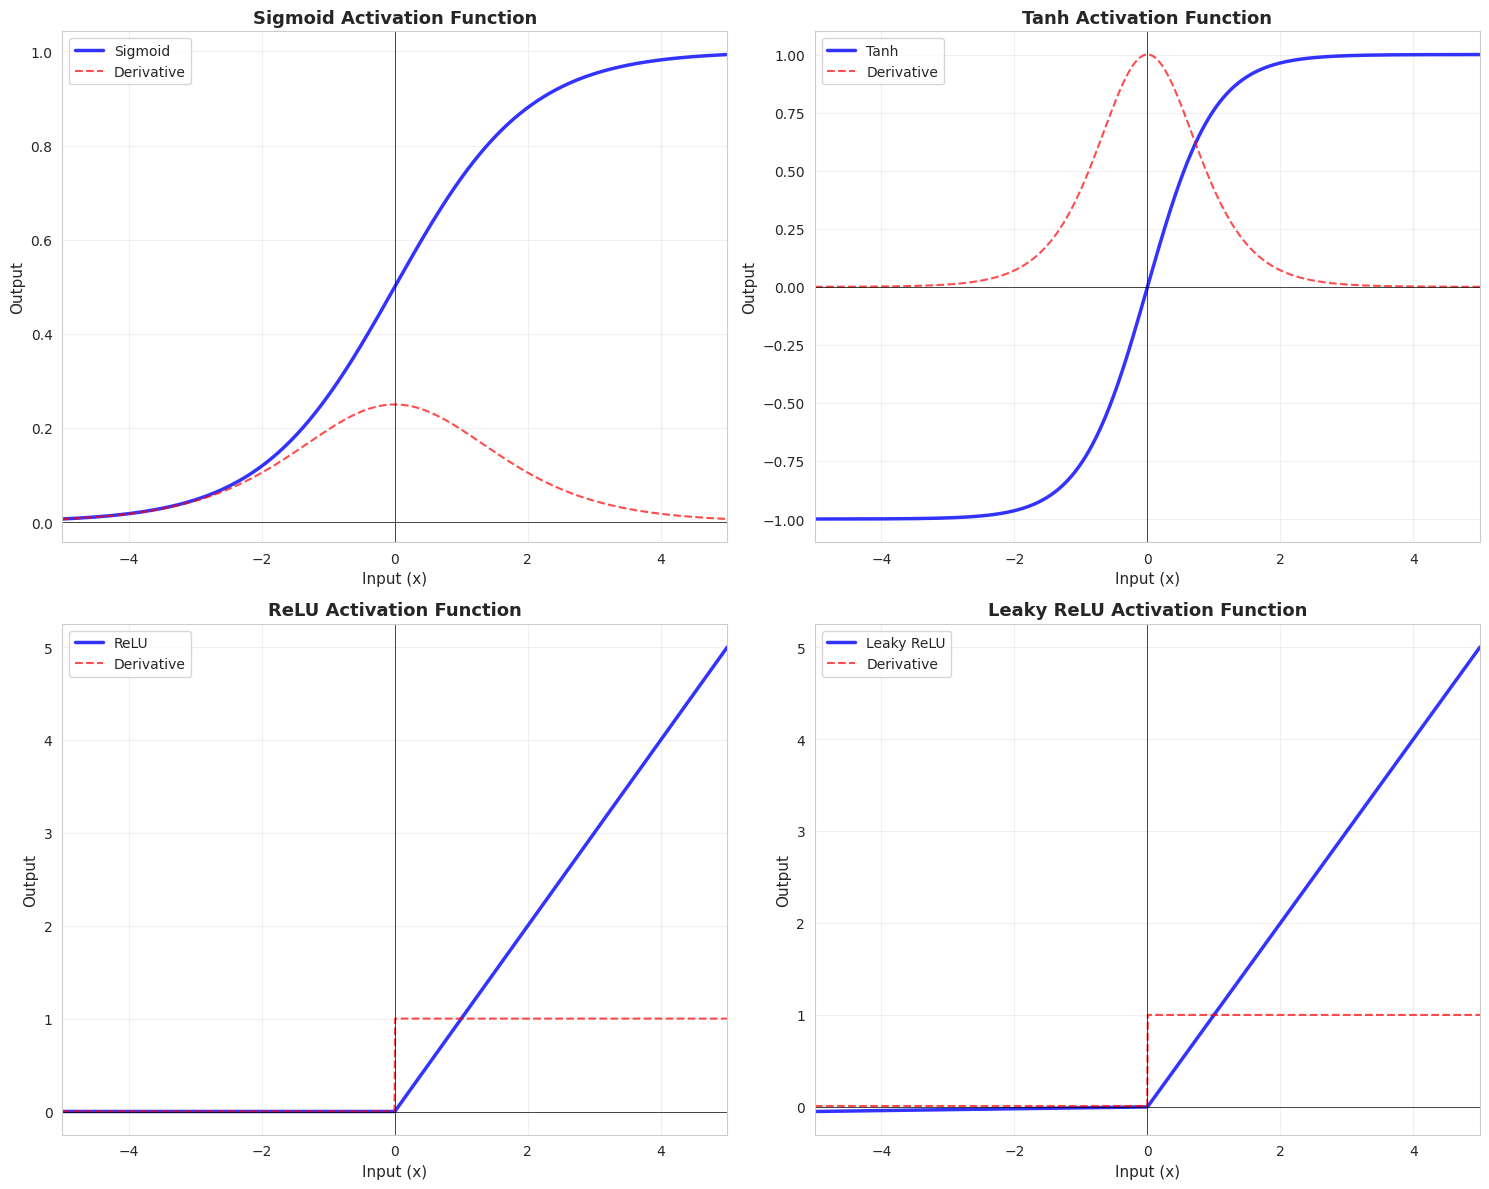

Activation Function Properties:
Sigmoid:     Output (0,1)   | Vanishing gradient problem
Tanh:        Output (-1,1)  | Zero-centered, still vanishes
ReLU:        Output [0,∞)   | Fast, no vanishing, dead neurons
Leaky ReLU:  Output (-∞,∞)  | Prevents dead neurons


In [3]:
# 活性化関数とその微分の可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

activations = [
    ('Sigmoid', sigmoid(x), sigmoid_derivative(x)),
    ('Tanh', tanh(x), tanh_derivative(x)),
    ('ReLU', relu(x), relu_derivative(x)),
    ('Leaky ReLU', leaky_relu(x), leaky_relu_derivative(x))
]

for idx, (name, y, dy) in enumerate(activations):
    ax = axes.ravel()[idx]
    
    # 関数
    ax.plot(x, y, 'b-', lw=2.5, label=f'{name}', alpha=0.8)
    # 微分
    ax.plot(x, dy, 'r--', lw=1.5, label='Derivative', alpha=0.7)
    
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Input (x)', fontsize=11)
    ax.set_ylabel('Output', fontsize=11)
    ax.set_title(f'{name} Activation Function', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.set_xlim(-5, 5)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Activation Function Properties:")
print("="*60)
print("Sigmoid:     Output (0,1)   | Vanishing gradient problem")
print("Tanh:        Output (-1,1)  | Zero-centered, still vanishes")
print("ReLU:        Output [0,∞)   | Fast, no vanishing, dead neurons")
print("Leaky ReLU:  Output (-∞,∞)  | Prevents dead neurons")

### 活性化関数の比較

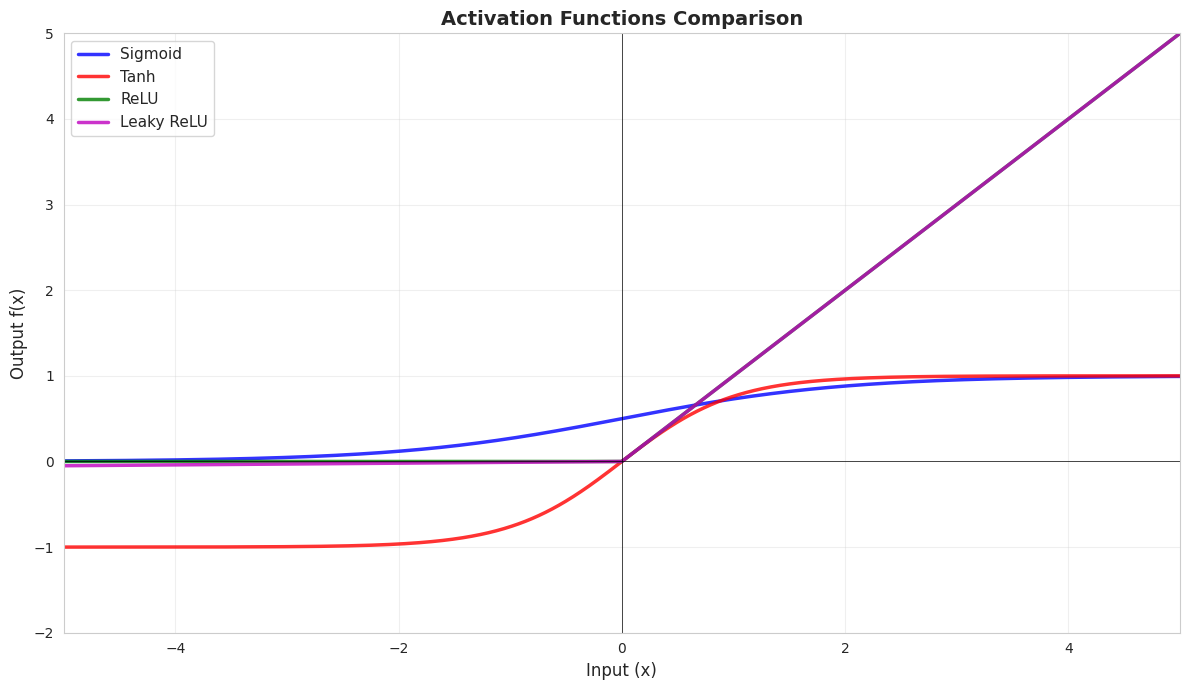

In [4]:
# すべての活性化関数を1つのグラフに
plt.figure(figsize=(12, 7))

plt.plot(x, sigmoid(x), 'b-', lw=2.5, label='Sigmoid', alpha=0.8)
plt.plot(x, tanh(x), 'r-', lw=2.5, label='Tanh', alpha=0.8)
plt.plot(x, relu(x), 'g-', lw=2.5, label='ReLU', alpha=0.8)
plt.plot(x, leaky_relu(x), 'm-', lw=2.5, label='Leaky ReLU', alpha=0.8)

plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
plt.xlabel('Input (x)', fontsize=12)
plt.ylabel('Output f(x)', fontsize=12)
plt.title('Activation Functions Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.xlim(-5, 5)
plt.ylim(-2, 5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 勾配消失問題

SigmoidとTanhは、入力の絶対値が大きいとき、微分が0に近づきます。これにより、深いネットワークで勾配が消失し、学習が困難になります。ReLUはこの問題を解決します。

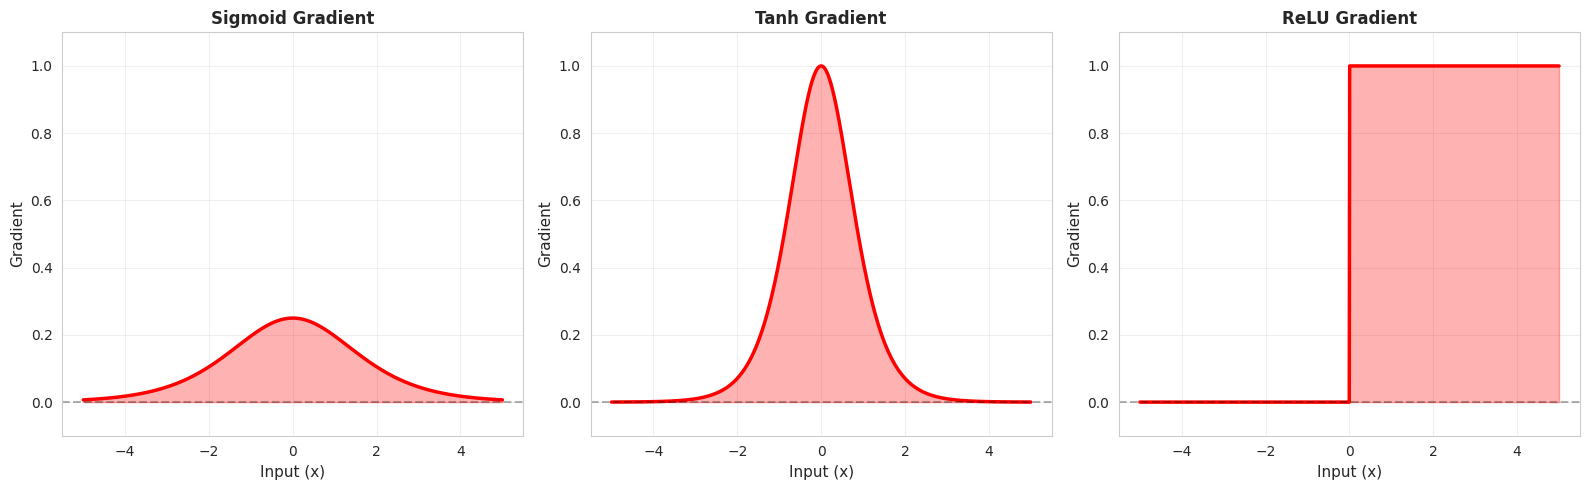

Gradient Analysis:
- Sigmoid: Max gradient = 0.25 (at x=0)
- Tanh:    Max gradient = 1.0 (at x=0)
- ReLU:    Gradient = 1.0 (for x>0), 0 (for x≤0)

ReLU avoids vanishing gradient problem!


In [5]:
# 勾配消失の可視化
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

derivatives = [
    ('Sigmoid', sigmoid_derivative(x)),
    ('Tanh', tanh_derivative(x)),
    ('ReLU', relu_derivative(x))
]

for idx, (name, dy) in enumerate(derivatives):
    axes[idx].plot(x, dy, 'r-', lw=2.5)
    axes[idx].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[idx].fill_between(x, 0, dy, alpha=0.3, color='red')
    axes[idx].set_xlabel('Input (x)', fontsize=11)
    axes[idx].set_ylabel('Gradient', fontsize=11)
    axes[idx].set_title(f'{name} Gradient', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

print("Gradient Analysis:")
print("- Sigmoid: Max gradient = 0.25 (at x=0)")
print("- Tanh:    Max gradient = 1.0 (at x=0)")
print("- ReLU:    Gradient = 1.0 (for x>0), 0 (for x≤0)")
print("\nReLU avoids vanishing gradient problem!")

---

## 2. MLPの構造: 層、ニューロン、パラメータ

### ネットワークの構成要素

1. **入力層 (Input Layer)**: 特徴量を受け取る
2. **隠れ層 (Hidden Layers)**: 特徴を変換・抽出
3. **出力層 (Output Layer)**: 予測を出力

各ニューロンは:
- **重み (Weights)**: 入力の重要度
- **バイアス (Bias)**: オフセット
- **活性化関数**: 非線形変換

### パラメータ数の計算

層 $i$ から層 $i+1$ への接続:
- 重み: $n_i \times n_{i+1}$
- バイアス: $n_{i+1}$
- 合計: $n_i \times n_{i+1} + n_{i+1}$

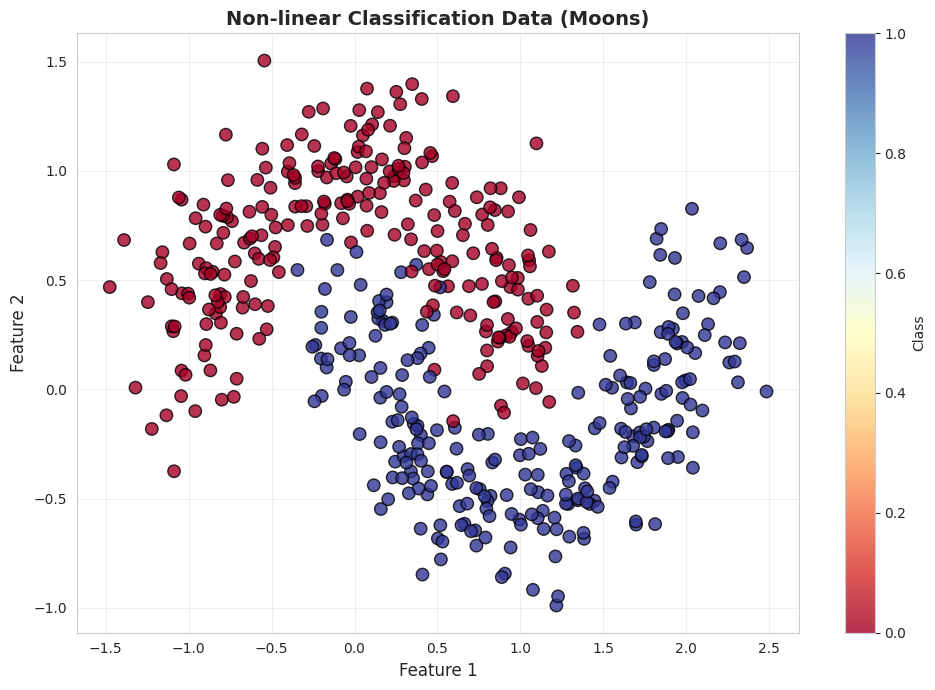

Training samples: 400
Test samples: 100
Features: 2
Classes: 2


In [6]:
# 簡単な非線形データの生成
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# データの標準化 (MLPでは必須!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# データの可視化
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black', s=80, alpha=0.8)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Non-linear Classification Data (Moons)', fontsize=14, fontweight='bold')
plt.colorbar(label='Class')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {X_train.shape[1]}")
print(f"Classes: {len(np.unique(y))}")

### シンプルなMLPモデルの構築

In [7]:
# 1隠れ層のMLPを訓練
mlp_simple = MLPClassifier(
    hidden_layer_sizes=(10,),  # 10ニューロンの隠れ層1つ
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.01,
    max_iter=1000,
    random_state=42
)

mlp_simple.fit(X_train_scaled, y_train)

print("MLP Architecture:")
print("="*60)
print(f"Input layer:    {X_train.shape[1]} features")
print(f"Hidden layers:  {mlp_simple.hidden_layer_sizes}")
print(f"Output layer:   {len(np.unique(y))} classes")
print(f"\nTraining:")
print(f"  Iterations:     {mlp_simple.n_iter_}")
print(f"  Final loss:     {mlp_simple.loss_:.6f}")
print(f"\nPerformance:")
print(f"  Train accuracy: {mlp_simple.score(X_train_scaled, y_train):.4f}")
print(f"  Test accuracy:  {mlp_simple.score(X_test_scaled, y_test):.4f}")

MLP Architecture:
Input layer:    2 features
Hidden layers:  (10,)
Output layer:   2 classes

Training:
  Iterations:     508
  Final loss:     0.046820

Performance:
  Train accuracy: 0.9800
  Test accuracy:  0.9800


### ネットワークパラメータの詳細

In [8]:
# 重みとバイアスの詳細
print("Network Parameters:")
print("="*60)

total_params = 0
for i, (w, b) in enumerate(zip(mlp_simple.coefs_, mlp_simple.intercepts_)):
    layer_params = w.size + b.size
    total_params += layer_params
    
    print(f"\nLayer {i+1}:")
    print(f"  Weights shape:      {w.shape}")
    print(f"  Biases shape:       {b.shape}")
    print(f"  Layer parameters:   {layer_params}")
    print(f"  Calculation:        {w.shape[0]} × {w.shape[1]} + {b.shape[0]} = {layer_params}")

print(f"\n{'='*60}")
print(f"Total network parameters: {total_params}")
print(f"\nThese parameters are learned during training!")

Network Parameters:

Layer 1:
  Weights shape:      (2, 10)
  Biases shape:       (10,)
  Layer parameters:   30
  Calculation:        2 × 10 + 10 = 30

Layer 2:
  Weights shape:      (10, 1)
  Biases shape:       (1,)
  Layer parameters:   11
  Calculation:        10 × 1 + 1 = 11

Total network parameters: 41

These parameters are learned during training!


### 決定境界の可視化

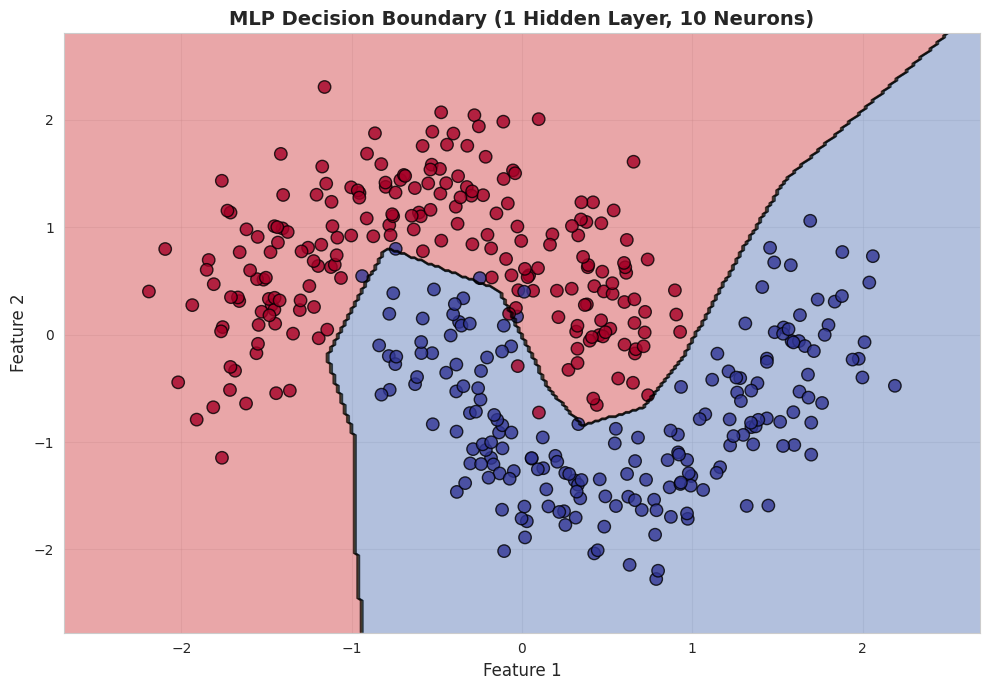

In [9]:
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    """MLPの決定境界を可視化"""
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    plt.contour(xx, yy, Z, colors='k', linewidths=0.8, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', 
                edgecolors='k', s=80, alpha=0.8)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_decision_boundary(mlp_simple, X_train_scaled, y_train, 
                      'MLP Decision Boundary (1 Hidden Layer, 10 Neurons)')

---

## 3. ニューロン数の影響

隠れ層のニューロン数は、ネットワークの**表現能力**を決定します:

- **少ないニューロン**: シンプルな境界 → 未学習のリスク
- **多いニューロン**: 複雑な境界 → 過学習のリスク

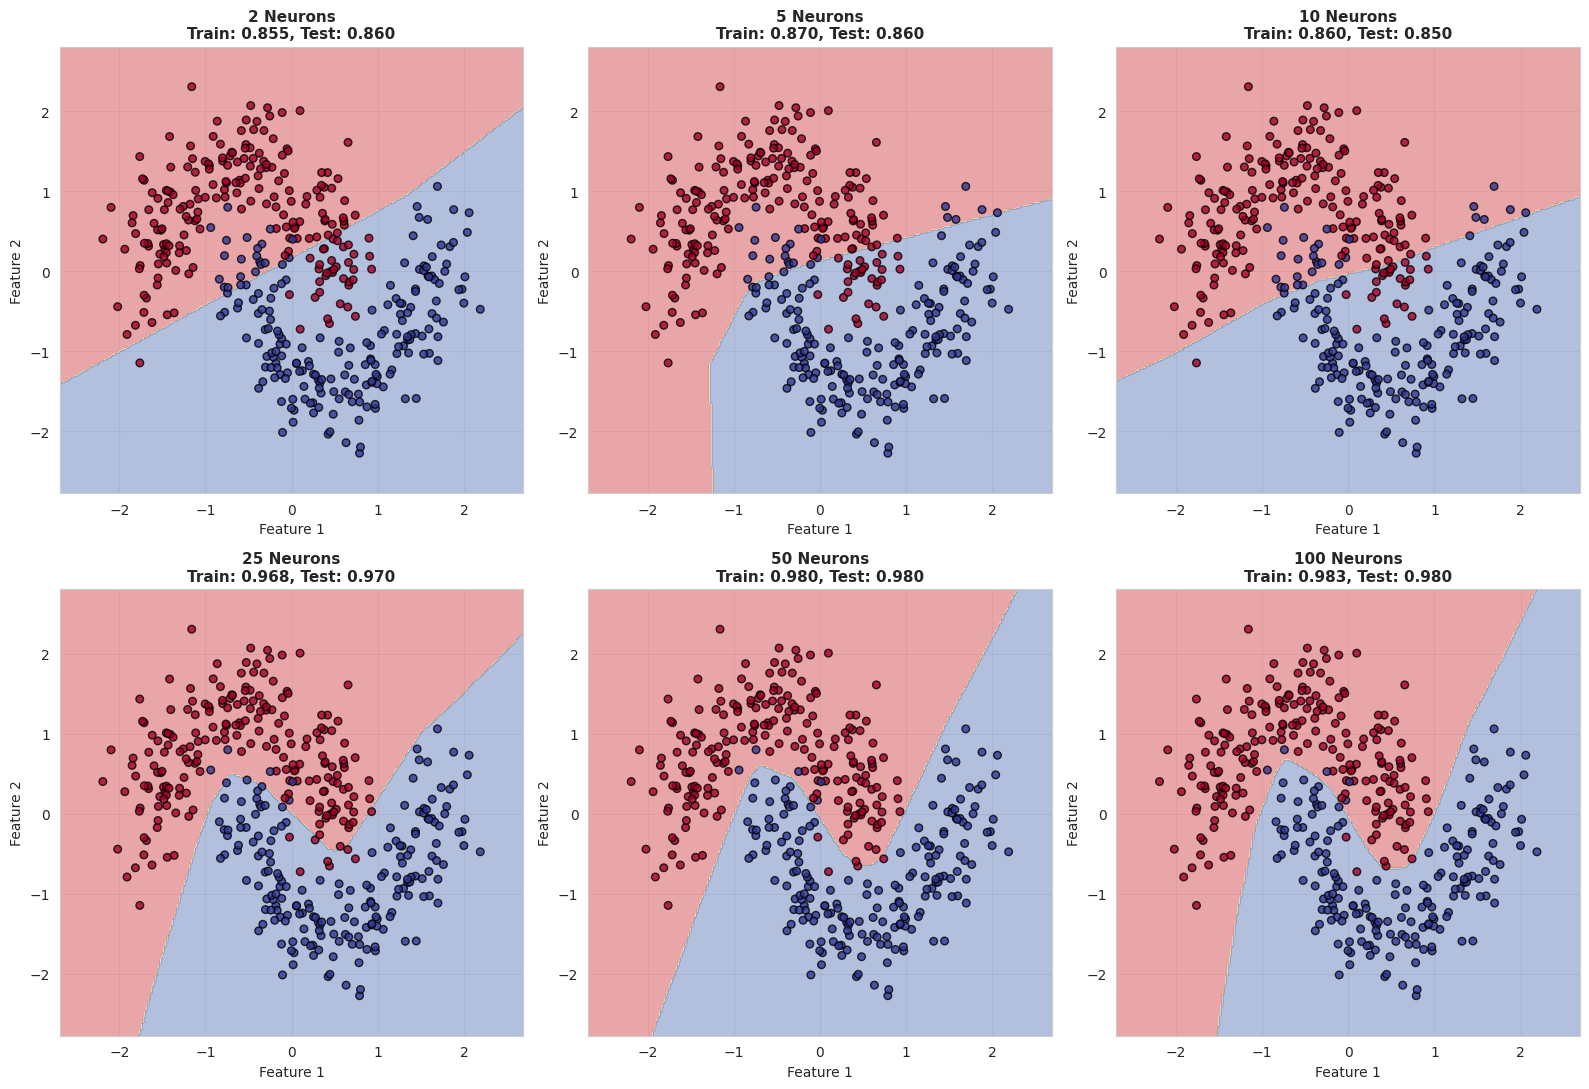


Observations:
- 2-5 neurons: Simple boundary, may underfit
- 10-25 neurons: Good balance
- 50-100 neurons: Complex boundary, may overfit


In [10]:
# 異なるニューロン数で比較
neuron_counts = [2, 5, 10, 25, 50, 100]

fig, axes = plt.subplots(2, 3, figsize=(16, 11))
axes = axes.ravel()

for idx, n_neurons in enumerate(neuron_counts):
    mlp = MLPClassifier(
        hidden_layer_sizes=(n_neurons,),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)
    
    acc_train = mlp.score(X_train_scaled, y_train)
    acc_test = mlp.score(X_test_scaled, y_test)
    
    # 決定境界
    h = 0.02
    x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
    y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    axes[idx].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, 
                      cmap='RdYlBu', edgecolors='k', s=30, alpha=0.8)
    axes[idx].set_xlabel('Feature 1', fontsize=10)
    axes[idx].set_ylabel('Feature 2', fontsize=10)
    axes[idx].set_title(f'{n_neurons} Neurons\nTrain: {acc_train:.3f}, Test: {acc_test:.3f}',
                        fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- 2-5 neurons: Simple boundary, may underfit")
print("- 10-25 neurons: Good balance")
print("- 50-100 neurons: Complex boundary, may overfit")

---

## 4. ネットワークの深さ: 層数の影響

**深さ (Depth)** は隠れ層の数を指します:

- **浅いネットワーク (1-2層)**: シンプルなパターン
- **深いネットワーク (3層以上)**: 階層的な特徴抽出

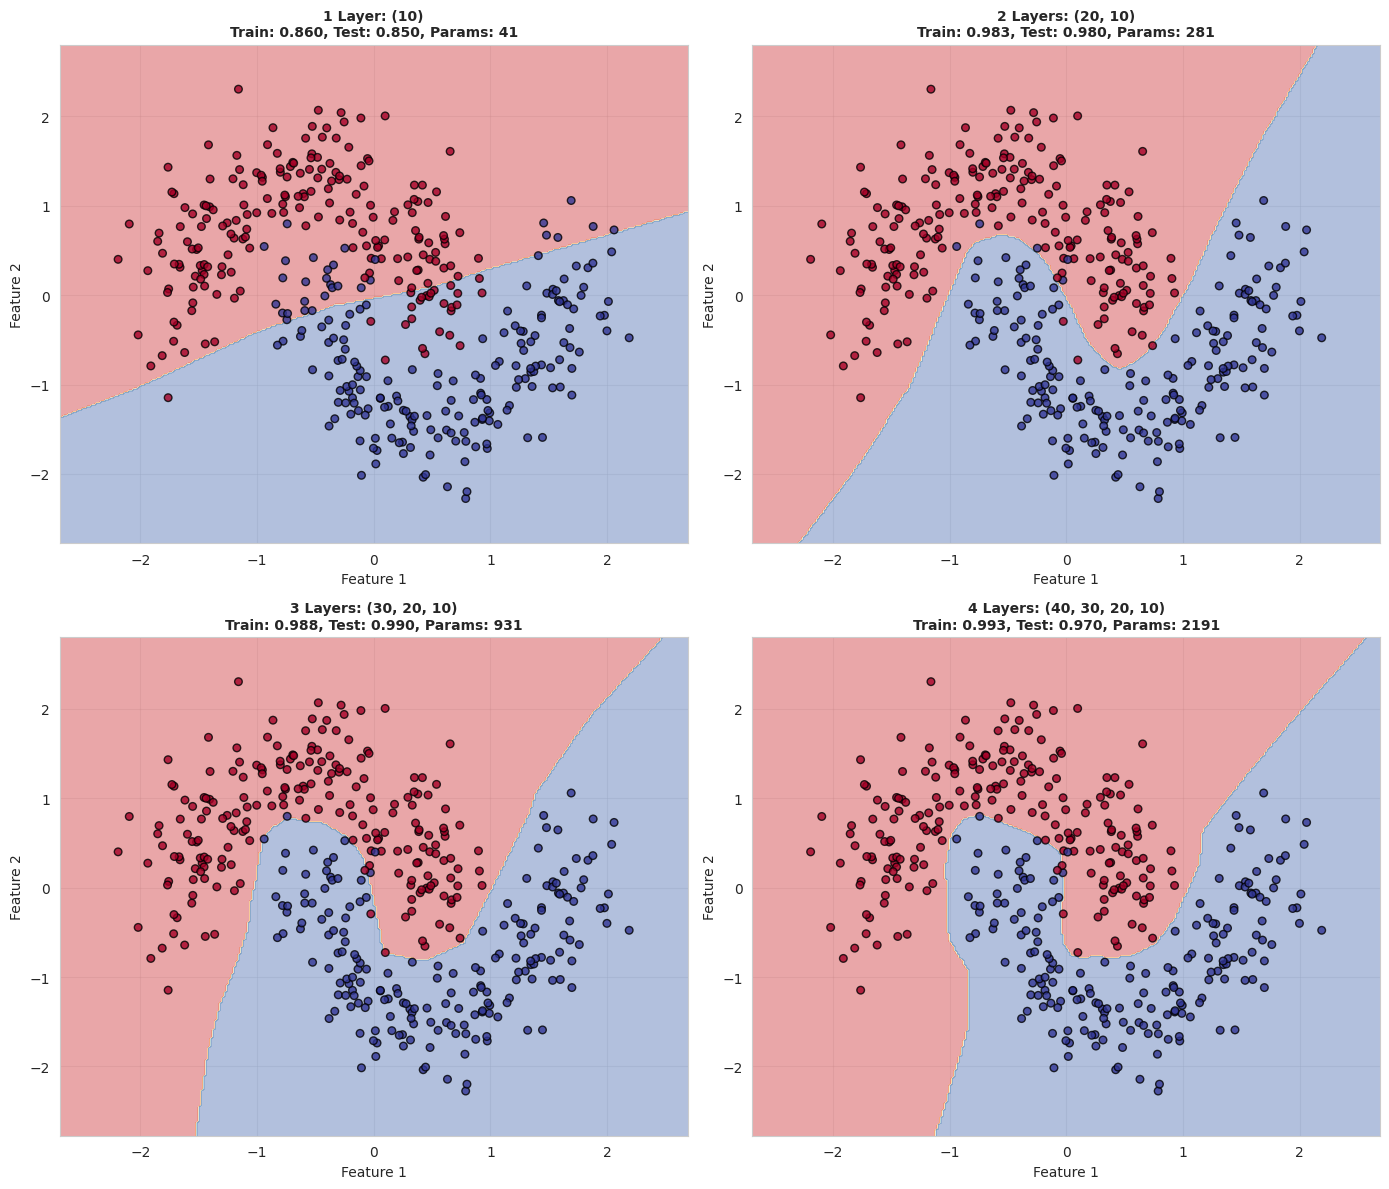


Architecture Comparison:
    Architecture  Depth  Parameters  Train Acc  Test Acc
           (10,)      1          41     0.8600      0.85
        (20, 10)      2         281     0.9825      0.98
    (30, 20, 10)      3         931     0.9875      0.99
(40, 30, 20, 10)      4        2191     0.9925      0.97


In [11]:
# 異なる深さのネットワークを比較
architectures = [
    ((10,), '1 Layer: (10)'),
    ((20, 10), '2 Layers: (20, 10)'),
    ((30, 20, 10), '3 Layers: (30, 20, 10)'),
    ((40, 30, 20, 10), '4 Layers: (40, 30, 20, 10)')
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

results = []

for idx, (arch, label) in enumerate(architectures):
    mlp = MLPClassifier(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)
    
    acc_train = mlp.score(X_train_scaled, y_train)
    acc_test = mlp.score(X_test_scaled, y_test)
    n_params = sum(w.size + b.size for w, b in zip(mlp.coefs_, mlp.intercepts_))
    
    results.append({
        'Architecture': str(arch),
        'Depth': len(arch),
        'Parameters': n_params,
        'Train Acc': acc_train,
        'Test Acc': acc_test
    })
    
    # 決定境界
    h = 0.02
    x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
    y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    axes[idx].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, 
                      cmap='RdYlBu', edgecolors='k', s=30, alpha=0.8)
    axes[idx].set_xlabel('Feature 1', fontsize=10)
    axes[idx].set_ylabel('Feature 2', fontsize=10)
    axes[idx].set_title(f'{label}\nTrain: {acc_train:.3f}, Test: {acc_test:.3f}, Params: {n_params}',
                        fontsize=10, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 結果をテーブルで表示
df_results = pd.DataFrame(results)
print("\nArchitecture Comparison:")
print(df_results.to_string(index=False))

---

## 5. 活性化関数の比較

実際のデータで、どの活性化関数が最適かを確認します。

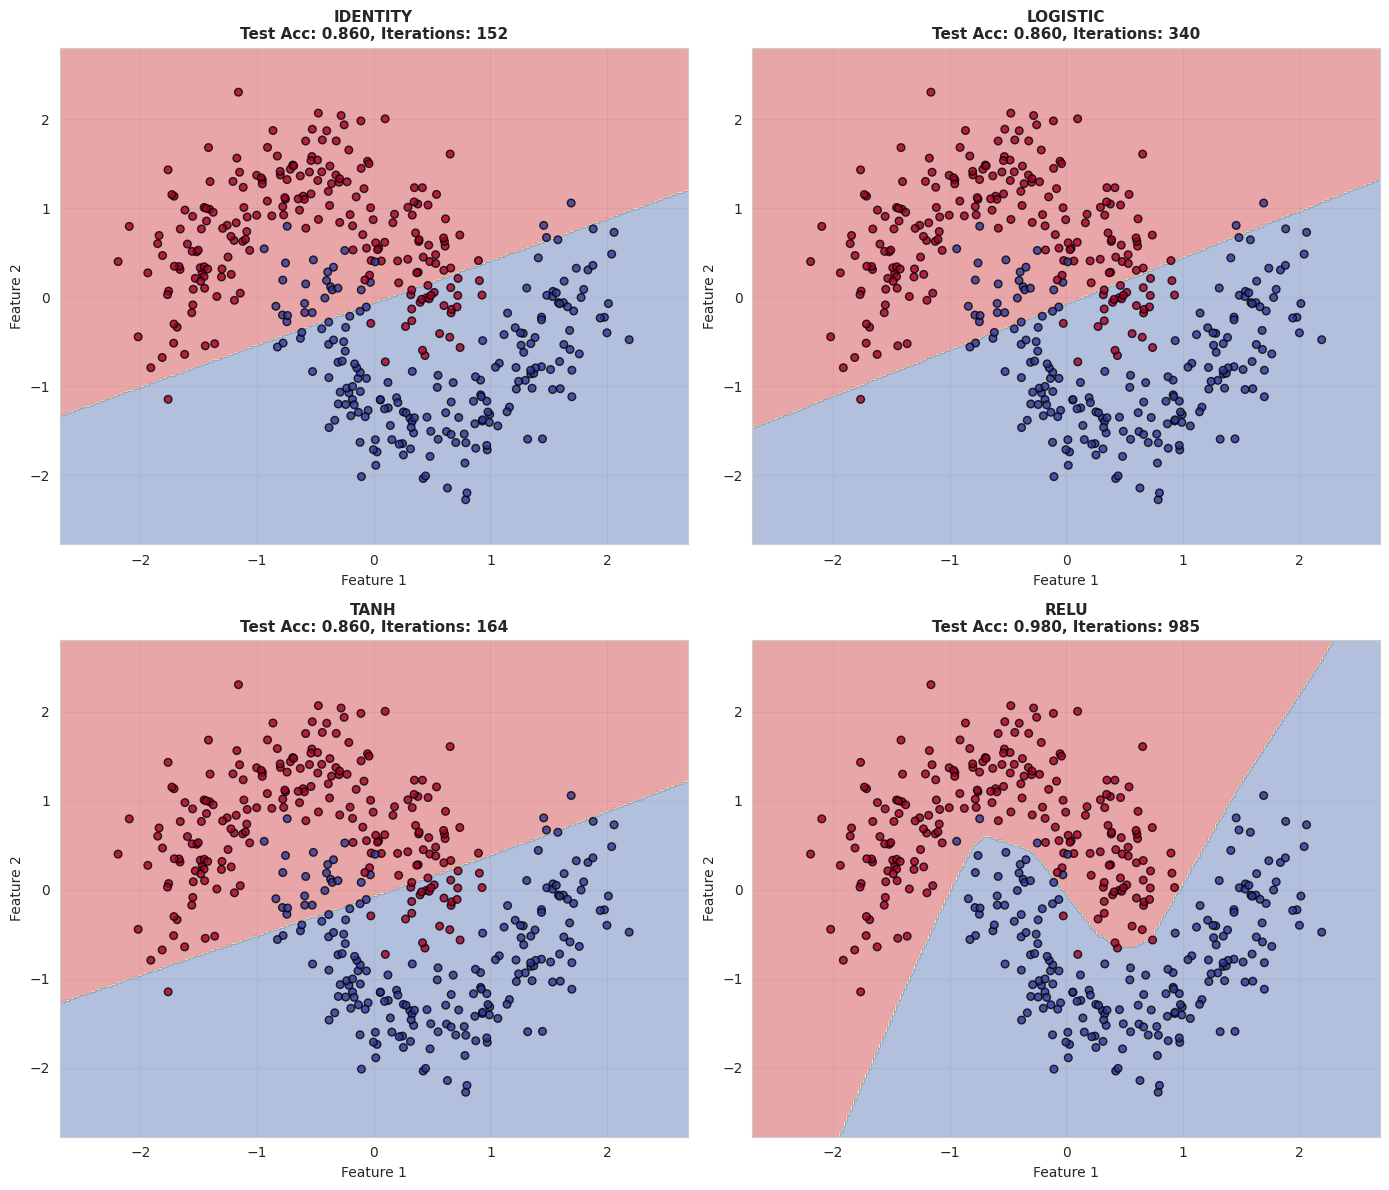


Activation Function Comparison:
Activation  Train Acc  Test Acc  Iterations
  identity     0.8600      0.86         152
  logistic     0.8600      0.86         340
      tanh     0.8625      0.86         164
      relu     0.9800      0.98         985

Best activation: ReLU (fast convergence, good performance)


In [12]:
# 異なる活性化関数で比較
activations = ['identity', 'logistic', 'tanh', 'relu']

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

activation_results = []

for idx, activation in enumerate(activations):
    mlp = MLPClassifier(
        hidden_layer_sizes=(50,),
        activation=activation,
        solver='adam',
        max_iter=1000,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)
    
    acc_train = mlp.score(X_train_scaled, y_train)
    acc_test = mlp.score(X_test_scaled, y_test)
    
    activation_results.append({
        'Activation': activation,
        'Train Acc': acc_train,
        'Test Acc': acc_test,
        'Iterations': mlp.n_iter_
    })
    
    # 決定境界
    h = 0.02
    x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
    y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = mlp.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axes[idx].contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    axes[idx].scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, 
                      cmap='RdYlBu', edgecolors='k', s=30, alpha=0.8)
    axes[idx].set_xlabel('Feature 1', fontsize=10)
    axes[idx].set_ylabel('Feature 2', fontsize=10)
    axes[idx].set_title(f'{activation.upper()}\nTest Acc: {acc_test:.3f}, Iterations: {mlp.n_iter_}',
                        fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

df_act = pd.DataFrame(activation_results)
print("\nActivation Function Comparison:")
print(df_act.to_string(index=False))
print("\nBest activation: ReLU (fast convergence, good performance)")

---

## 6. 学習曲線: 損失の推移

学習曲線は、訓練の進行を可視化し、収束を確認します。

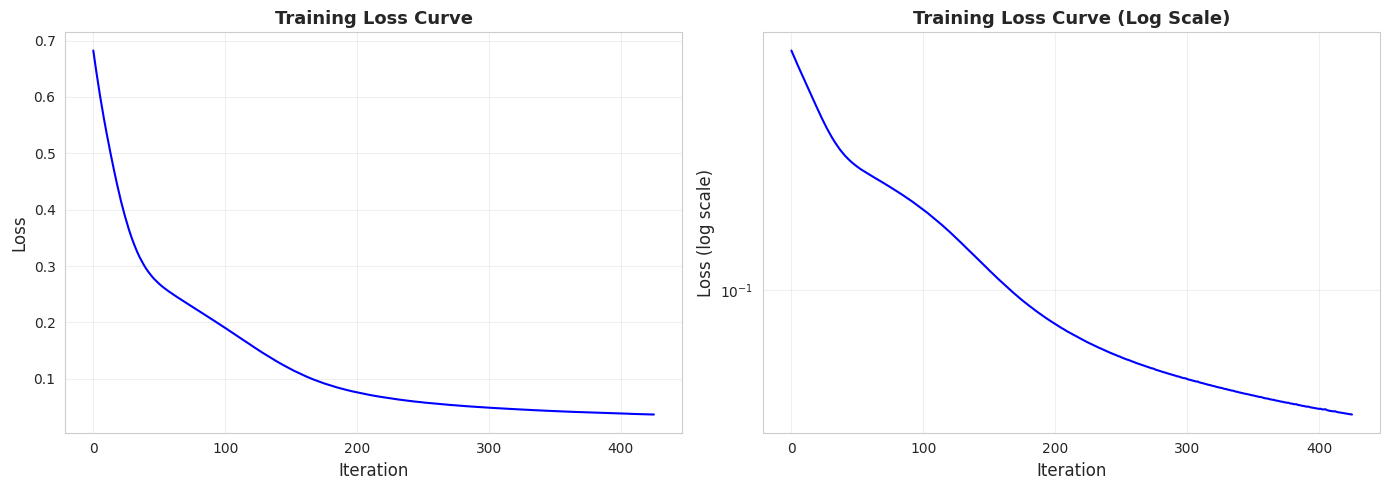

Final loss: 0.036741
Total iterations: 426
Training accuracy: 0.9825
Test accuracy: 0.9800


In [13]:
# 学習曲線を追跡
mlp_track = MLPClassifier(
    hidden_layer_sizes=(50, 25),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

mlp_track.fit(X_train_scaled, y_train)

# 損失曲線
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(mlp_track.loss_curve_, 'b-', linewidth=1.5)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Curve', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.semilogy(mlp_track.loss_curve_, 'b-', linewidth=1.5)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (log scale)', fontsize=12)
plt.title('Training Loss Curve (Log Scale)', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final loss: {mlp_track.loss_curve_[-1]:.6f}")
print(f"Total iterations: {mlp_track.n_iter_}")
print(f"Training accuracy: {mlp_track.score(X_train_scaled, y_train):.4f}")
print(f"Test accuracy: {mlp_track.score(X_test_scaled, y_test):.4f}")

### 学習率の影響

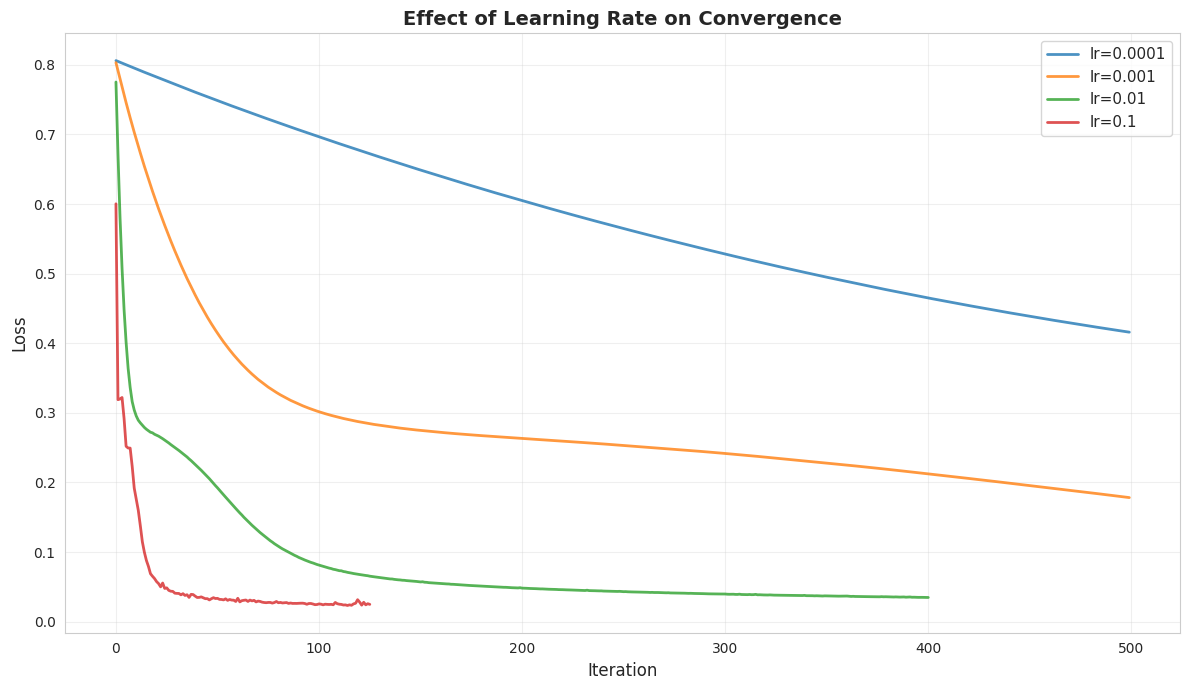

Learning Rate Effects:
- Too small (0.0001): Slow convergence
- Optimal (0.001-0.01): Balanced convergence
- Too large (0.1): Oscillating or diverging


In [14]:
# 異なる学習率で比較
learning_rates = [0.0001, 0.001, 0.01, 0.1]

plt.figure(figsize=(12, 7))

for lr in learning_rates:
    mlp = MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='relu',
        solver='adam',
        learning_rate_init=lr,
        max_iter=500,
        random_state=42
    )
    mlp.fit(X_train_scaled, y_train)
    
    plt.plot(mlp.loss_curve_, label=f'lr={lr}', linewidth=2, alpha=0.8)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Effect of Learning Rate on Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Learning Rate Effects:")
print("- Too small (0.0001): Slow convergence")
print("- Optimal (0.001-0.01): Balanced convergence")
print("- Too large (0.1): Oscillating or diverging")

---

## 7. 実践例: 手書き数字認識

より実践的な問題で、MLPの能力を試します。

Digits Dataset:
Samples: 1797
Features: 64 (8x8 pixel images)
Classes: 10 (digits 0-9)


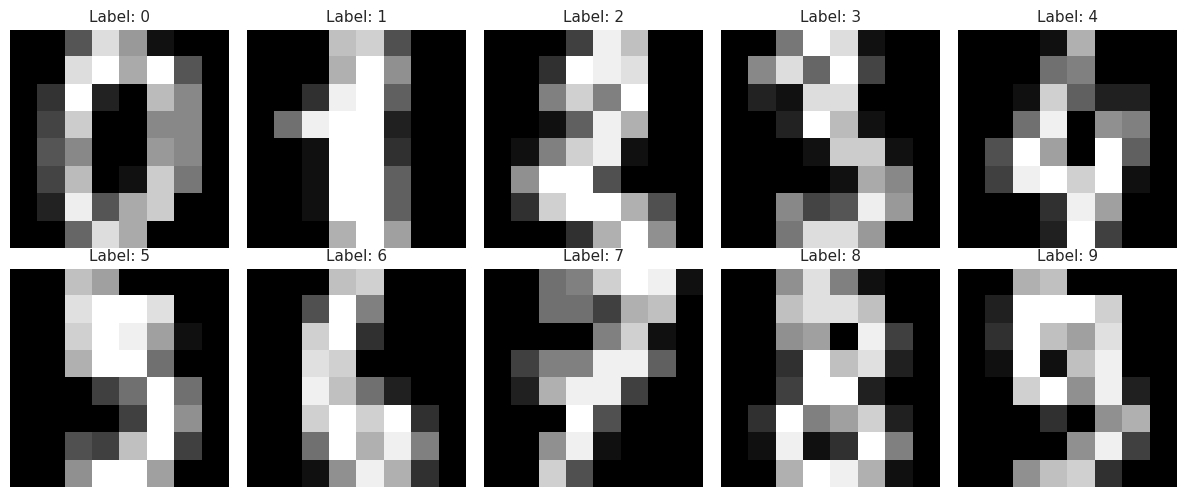

In [15]:
# 手書き数字データセット
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print("Digits Dataset:")
print(f"Samples: {X_digits.shape[0]}")
print(f"Features: {X_digits.shape[1]} (8x8 pixel images)")
print(f"Classes: {len(np.unique(y_digits))} (digits 0-9)")

# サンプル画像を表示
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx, ax in enumerate(axes.ravel()):
    ax.imshow(digits.images[idx], cmap='gray')
    ax.set_title(f'Label: {y_digits[idx]}', fontsize=11)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# データの分割と前処理
X_train_dig, X_test_dig, y_train_dig, y_test_dig = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42, stratify=y_digits
)

scaler_dig = StandardScaler()
X_train_dig_scaled = scaler_dig.fit_transform(X_train_dig)
X_test_dig_scaled = scaler_dig.transform(X_test_dig)

# MLPモデルの訓練
mlp_digits = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

mlp_digits.fit(X_train_dig_scaled, y_train_dig)

# 評価
y_pred_dig = mlp_digits.predict(X_test_dig_scaled)

print("\nMLP Performance on Digits:")
print("="*60)
print(f"Training accuracy: {mlp_digits.score(X_train_dig_scaled, y_train_dig):.4f}")
print(f"Test accuracy: {mlp_digits.score(X_test_dig_scaled, y_test_dig):.4f}")
print(f"Iterations: {mlp_digits.n_iter_}")

print("\nClassification Report:")
print(classification_report(y_test_dig, y_pred_dig))


MLP Performance on Digits:
Training accuracy: 1.0000
Test accuracy: 0.9778
Iterations: 92

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.92      0.97      0.95        36
           2       0.97      1.00      0.99        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.97      1.00      0.99        36
           8       0.94      0.86      0.90        35
           9       1.00      0.97      0.99        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



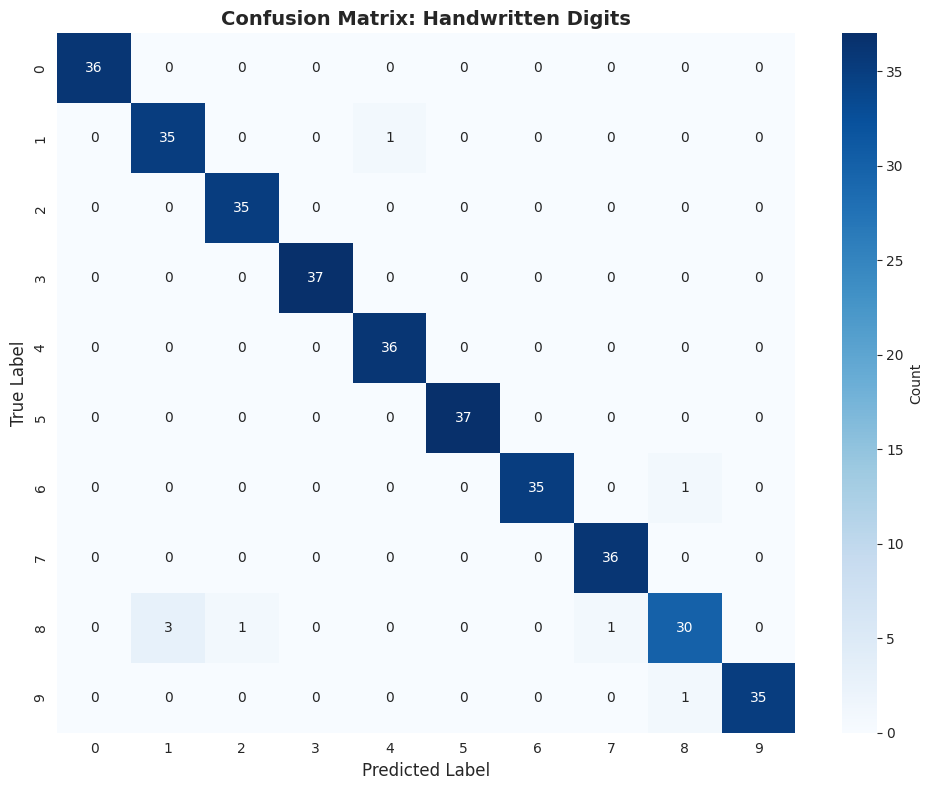

In [17]:
# 混同行列
cm = confusion_matrix(y_test_dig, y_pred_dig)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix: Handwritten Digits', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

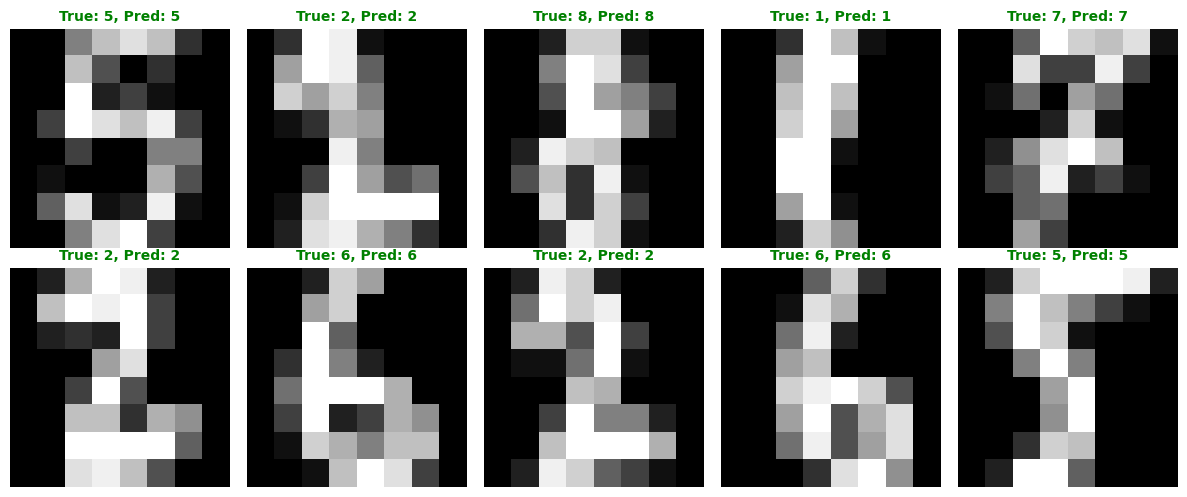

In [18]:
# 予測の可視化
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for idx, ax in enumerate(axes.ravel()):
    image = X_test_dig[idx].reshape(8, 8)
    true_label = y_test_dig[idx]
    pred_label = y_pred_dig[idx]
    
    ax.imshow(image, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', 
                 fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

---

## 8. 他のモデルとの比較

In [19]:
# 複数のモデルを比較
from sklearn.ensemble import RandomForestClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'MLP (50)': MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
    'MLP (100,50)': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

comparison_results = []

for name, model in models.items():
    model.fit(X_train_dig_scaled, y_train_dig)
    train_acc = model.score(X_train_dig_scaled, y_train_dig)
    test_acc = model.score(X_test_dig_scaled, y_test_dig)
    cv_scores = cross_val_score(model, X_train_dig_scaled, y_train_dig, cv=5)
    
    comparison_results.append({
        'Model': name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })

df_comparison = pd.DataFrame(comparison_results).sort_values('Test Acc', ascending=False)

print("\nModel Comparison on Digits Dataset:")
print("="*60)
print(df_comparison.to_string(index=False))


Model Comparison on Digits Dataset:
              Model  Train Acc  Test Acc  CV Mean   CV Std
       MLP (100,50)   1.000000  0.977778 0.975639 0.006249
Logistic Regression   0.999304  0.972222 0.970069 0.008441
           MLP (50)   1.000000  0.972222 0.974245 0.010254
      Random Forest   1.000000  0.961111 0.974238 0.012971
      Decision Tree   0.987474  0.808333 0.842005 0.022265


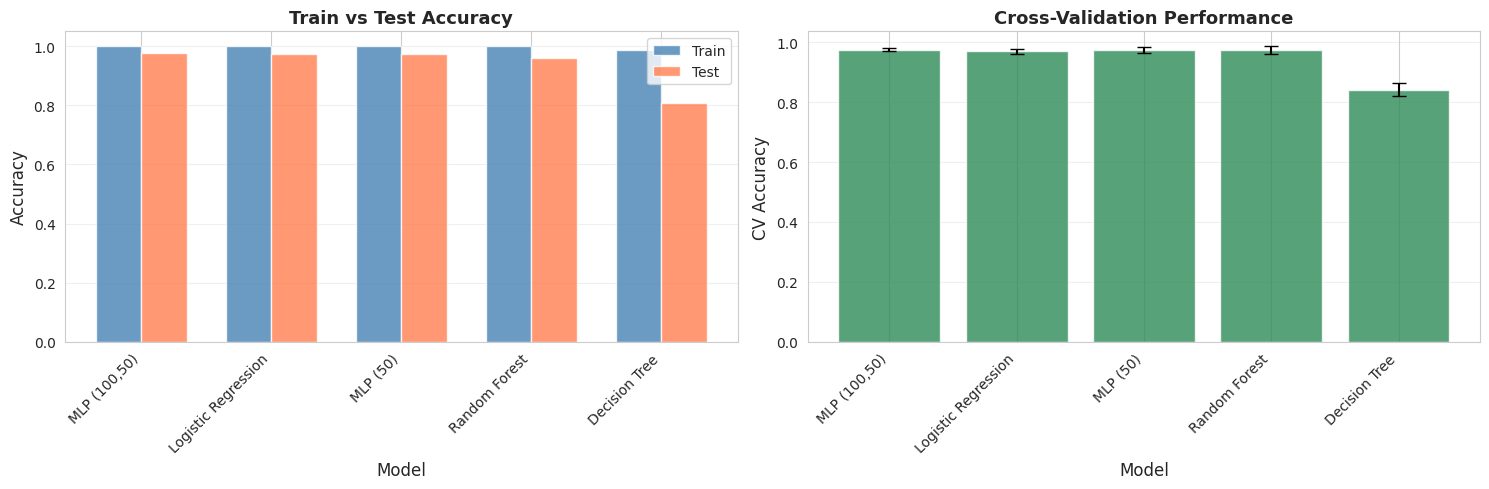

In [20]:
# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train vs Test Accuracy
x = np.arange(len(df_comparison))
width = 0.35

axes[0].bar(x - width/2, df_comparison['Train Acc'], width, 
            label='Train', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, df_comparison['Test Acc'], width, 
            label='Test', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Train vs Test Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# CV Mean with Error Bars
axes[1].bar(x, df_comparison['CV Mean'], yerr=df_comparison['CV Std'], 
            alpha=0.8, color='seagreen', capsize=5)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('CV Accuracy', fontsize=12)
axes[1].set_title('Cross-Validation Performance', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---

## まとめ

### MLPの主要ポイント

1. **ニューラルネットワークの構造**
   - 入力層 → 隠れ層 → 出力層
   - 各層のニューロンは重みとバイアスを持つ
   - 活性化関数で非線形変換

2. **活性化関数**
   - ReLU: 現代のデフォルト (高速、勾配消失なし)
   - Sigmoid/Tanh: 勾配消失問題あり
   - Leaky ReLU: Dead neuron問題を軽減

3. **アーキテクチャの選択**
   - ニューロン数: 50-100から開始
   - 層数: 1-2層で開始、必要に応じて深くする
   - パラメータ数: $(n_i \times n_{i+1}) + n_{i+1}$

4. **学習のポイント**
   - **必ずスケーリング**: StandardScalerを使用
   - 学習率: 0.001から開始 (Adam)
   - Early stopping: 過学習を防止
   - 損失曲線: 収束を確認

5. **診断**
   - 学習曲線で過学習/未学習を判定
   - 決定境界で複雑さを確認
   - Cross-validationで汎化性能を評価

### MLPの長所と短所

**長所:**
- 非線形パターンを効果的に学習
- 柔軟なアーキテクチャ
- 多様なタスクに適用可能
- 特徴量エンジニアリングが不要

**短所:**
- ブラックボックスモデル (解釈性が低い)
- ハイパーパラメータが多い
- スケーリングが必須
- 訓練に時間がかかる場合がある

### 実践的なガイドライン

1. **データの前処理**: 必ずStandardScalerで標準化
2. **シンプルから開始**: (50,) または (100,)
3. **ReLUを使用**: 特別な理由がない限り
4. **Early stoppingを有効化**: 過学習を防止
5. **学習曲線を確認**: 収束と過学習をチェック
6. **Cross-validationで評価**: テストセットだけに頼らない

---

## 練習問題

1. **活性化関数の実験**: 異なるデータセット (make_circles) で活性化関数を比較してください
2. **アーキテクチャ探索**: 最適な層数とニューロン数を見つけてください
3. **学習率の調整**: 異なる学習率で収束速度を比較してください
4. **他のデータセット**: IrisやワインデータセットでMLPを試してください
5. **正則化**: alphaパラメータを変えて過学習を制御してください

---

**次のステップ**: ノートブック08で、MLPのハイパーパラメータ空間を体系的に探索します!
